In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from datetime import datetime
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns
import warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning

warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)


In [11]:
# -------------------------------
# 1. Load Data
# -------------------------------
# CSV should have columns: Date, Price
df = pd.read_csv("Downloads/Nat_Gas.csv")



In [12]:
df['Dates'] = pd.to_datetime(df['Dates'], errors='coerce')

# Optional: check which rows had date issues
print(df[df['Dates'].isna()])

# Remove invalid dates
df = df.dropna(subset=['Dates'])

# Sort & set index
df = df.sort_values('Dates')
df.set_index('Dates', inplace=True)


Empty DataFrame
Columns: [Dates, Prices]
Index: []


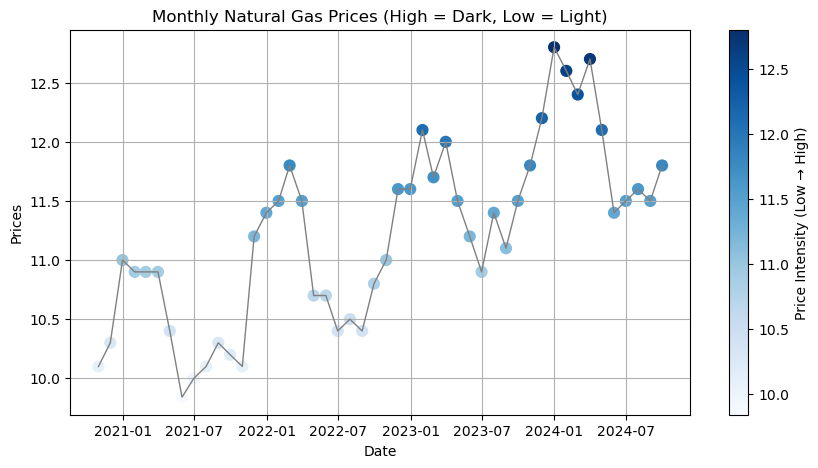

In [16]:
# -------------------------------
# 2. Visualization
# -------------------------------

# Normalize prices
norm = mcolors.Normalize(
    vmin=df['Prices'].min(),
    vmax=df['Prices'].max()
)

# Choose colormap (dark = high, light = low)
cmap = plt.cm.Blues

plt.figure(figsize=(10,5))

# Line (neutral color)
plt.plot(df.index, df['Prices'], color='gray', linewidth=1)

# Scatter with color intensity
plt.scatter(
    df.index,
    df['Prices'],
    c=df['Prices'],
    cmap=cmap,
    norm=norm,
    s=60
)

plt.colorbar(label="Price Intensity (Low → High)")
plt.title("Monthly Natural Gas Prices (High = Dark, Low = Light)")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.grid()
plt.show()

# plt.figure(figsize=(10,5))
# plt.plot(df.index, df['Prices'], marker='o')
# plt.title("Monthly Natural Gas Prices")
# plt.xlabel("Date")
# plt.ylabel("Prices")
# plt.grid()
# plt.show()


In [18]:
# -------------------------------
# 3. Seasonality Calculation
# -------------------------------
df['Month'] = df.index.month
monthly_seasonality = df.groupby('Month')['Prices'].mean()


In [20]:
# -------------------------------
# 4. Trend Model (Linear Regression)
# -------------------------------
df['TimeIndex'] = np.arange(len(df))
coeff = np.polyfit(df['TimeIndex'], df['Prices'], 1)

def trend_price(t):
    return coeff[0] * t + coeff[1]


In [21]:
# -------------------------------
# 5. Price Estimation Function
# -------------------------------
def estimate_gas_price(input_date):
    """
    input_date: 'YYYY-MM-DD'
    returns estimated gas price
    """

    input_date = pd.to_datetime(input_date)

    # Past date interpolation
    if input_date <= df.index.max():
        price = np.interp(
            input_date.timestamp(),
            df.index.astype(np.int64),
            df['Prices']   # ✅ FIXED HERE
        )
        return round(price, 2)

    # Future extrapolation (1 year max)
    else:
        months_ahead = (
            (input_date.year - df.index.max().year) * 12
            + (input_date.month - df.index.max().month)
        )

        if months_ahead > 12:
            raise ValueError("Extrapolation limited to 1 year only")

        future_index = len(df) + months_ahead
        base_price = trend_price(future_index)

        seasonal_adj = (
            monthly_seasonality[input_date.month]
            - monthly_seasonality.mean()
        )

        return round(base_price + seasonal_adj, 2)

In [22]:
print(df.columns)

Index(['Prices', 'Month', 'TimeIndex'], dtype='object')


In [23]:
# -------------------------------
# 6. Example Usage
# -------------------------------
print("Past Price Estimate:", estimate_gas_price("2022-06-15"))
print("Future Price Estimate:", estimate_gas_price("2025-03-31"))


Past Price Estimate: 10.1
Future Price Estimate: 12.96


In [24]:
# -------------------------------
# 7. SARIMA Model
# -------------------------------
model = SARIMAX(
    df['Prices'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


In [25]:
# -------------------------------
# 8. Forecast Next 12 Months
# -------------------------------
future_forecast = results.get_forecast(steps=12)
future_prices = future_forecast.predicted_mean

# Create future dates
future_dates = pd.date_range(
    start=df.index.max() + pd.offsets.MonthEnd(1),
    periods=12,
    freq='M'
)

forecast_df = pd.DataFrame({
    'Date': future_dates,
    'ForecastPrice': future_prices.values
}).set_index('Date')



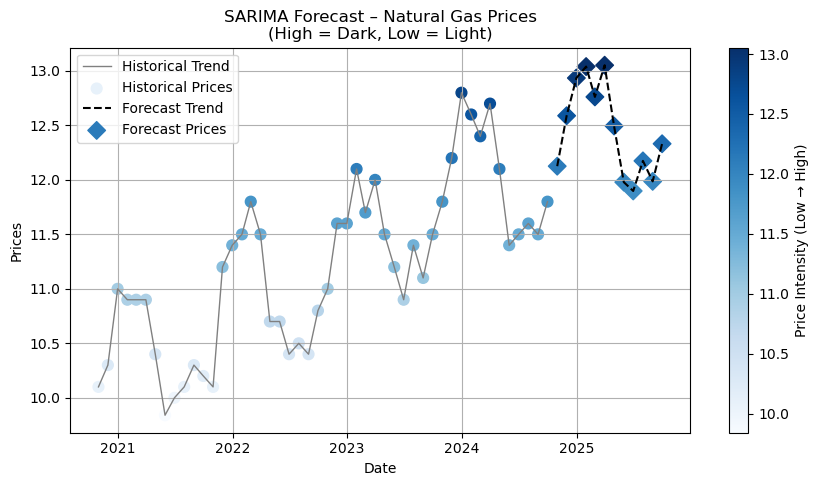

In [27]:
# -------------------------------
# 9. Plot Forecast
# -------------------------------

# Combine historical + forecast for common normalization
all_prices = pd.concat([df['Prices'], forecast_df['ForecastPrice']])

norm = mcolors.Normalize(
    vmin=all_prices.min(),
    vmax=all_prices.max()
)

cmap = plt.cm.Blues  # High = dark, Low = light

plt.figure(figsize=(10,5))

# Historical line (neutral)
plt.plot(df.index, df['Prices'], color='gray', linewidth=1, label='Historical Trend')

# Historical scatter (value-based color)
plt.scatter(
    df.index,
    df['Prices'],
    c=df['Prices'],
    cmap=cmap,
    norm=norm,
    s=60,
    label='Historical Prices'
)

# Forecast line
plt.plot(
    forecast_df.index,
    forecast_df['ForecastPrice'],
    linestyle='--',
    color='black',
    label='Forecast Trend'
)

# Forecast scatter (value-based color)
plt.scatter(
    forecast_df.index,
    forecast_df['ForecastPrice'],
    c=forecast_df['ForecastPrice'],
    cmap=cmap,
    norm=norm,
    s=80,
    marker='D',
    label='Forecast Prices'
)

plt.colorbar(label="Price Intensity (Low → High)")
plt.title("SARIMA Forecast – Natural Gas Prices\n(High = Dark, Low = Light)")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.grid()
plt.show()
# plt.figure(figsize=(10,5))
# plt.plot(df.index, df['Prices'], label='Historical')
# plt.plot(forecast_df.index, forecast_df['ForecastPrice'], label='Forecast', linestyle='--')
# plt.legend()
# plt.title("SARIMA Forecast – Natural Gas Prices")
# plt.grid()
# plt.show()


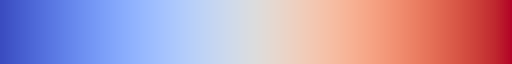

In [28]:
plt.cm.Reds
plt.cm.Greens
plt.cm.Purples
plt.cm.coolwarm

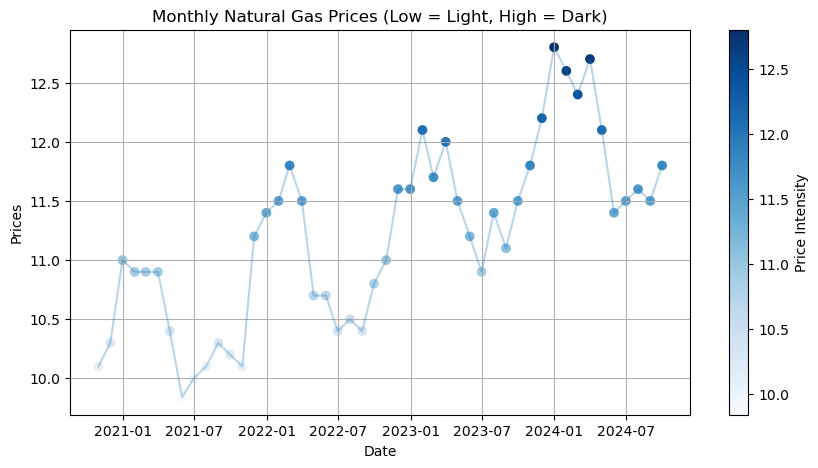

In [31]:
# -------------------------------
# 10. Price Estimation Function
# -------------------------------

plt.figure(figsize=(10,5))

# Normalize prices for color intensity
norm = mcolors.Normalize(
    vmin=df['Prices'].min(),
    vmax=df['Prices'].max()
)

# Scatter with color mapping
plt.scatter(
    df.index,
    df['Prices'],
    c=df['Prices'],
    cmap='Blues',        # light → dark blue
    norm=norm
)

# Line for trend
plt.plot(df.index, df['Prices'], alpha=0.3)

plt.colorbar(label='Price Intensity')
plt.title("Monthly Natural Gas Prices (Low = Light, High = Dark)")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.grid()
plt.show()

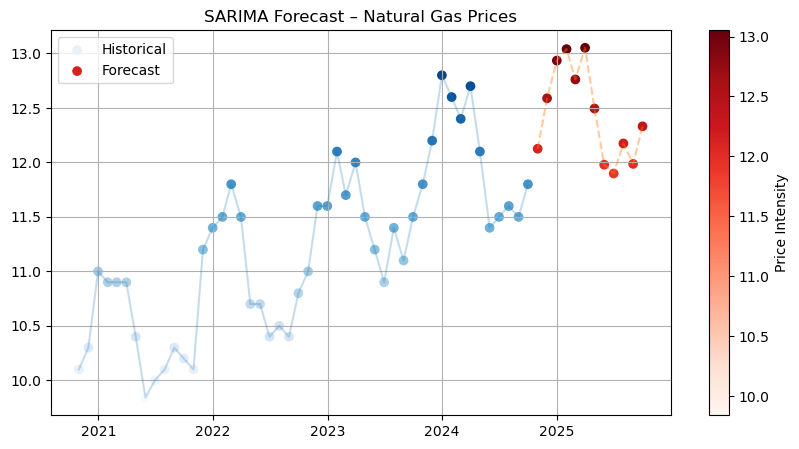

In [32]:
# Historical + Forecast Plot
plt.figure(figsize=(10,5))

# Combine values for consistent color scale
all_prices = pd.concat([
    df['Prices'],
    forecast_df['ForecastPrice']
])

norm = mcolors.Normalize(
    vmin=all_prices.min(),
    vmax=all_prices.max()
)

# Historical
plt.scatter(
    df.index,
    df['Prices'],
    c=df['Prices'],
    cmap='Blues',
    norm=norm,
    label='Historical'
)

# Forecast
plt.scatter(
    forecast_df.index,
    forecast_df['ForecastPrice'],
    c=forecast_df['ForecastPrice'],
    cmap='Reds',
    norm=norm,
    label='Forecast'
)

plt.plot(df.index, df['Prices'], alpha=0.25)
plt.plot(forecast_df.index, forecast_df['ForecastPrice'], linestyle='--', alpha=0.4)

plt.colorbar(label='Price Intensity')
plt.title("SARIMA Forecast – Natural Gas Prices")
plt.legend()
plt.grid()
plt.show()

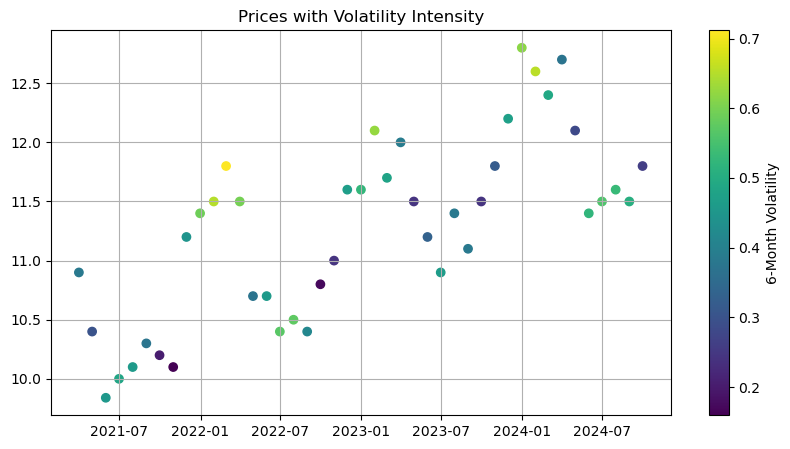

In [33]:
# Rolling volatility color idea (advanced look)
volatility = df['Prices'].rolling(6).std()

plt.figure(figsize=(10,5))
plt.scatter(
    df.index,
    df['Prices'],
    c=volatility,
    cmap='viridis'
)
plt.colorbar(label='6-Month Volatility')
plt.title("Prices with Volatility Intensity")
plt.grid()
plt.show()

In [35]:
# -------------------------------
# 11. Example Usage
# -------------------------------
def estimate_gas_price_sarima(input_date):
    """
    input_date: 'YYYY-MM-DD'
    Returns estimated gas price using SARIMA
    """

    input_date = pd.to_datetime(input_date)

    # Past date → interpolate
    if input_date <= df.index.max():
        value = (
            df['Prices']
            .reindex(df.index.union([input_date]))
            .interpolate()
            .loc[input_date]
        )
        return round(float(value), 2)

    # Future date (within forecast)
    elif input_date <= forecast_df.index.max():
        nearest_month = input_date.to_period('M').to_timestamp('M')
        return round(float(forecast_df.loc[nearest_month, 'ForecastPrice']), 2)

    else:
        raise ValueError("Forecast available only for next 12 months")


In [36]:
print("Past Estimate:", estimate_gas_price_sarima("2022-07-15"))
print("Future Estimate:", estimate_gas_price_sarima("2025-02-28"))

Past Estimate: 10.45
Future Estimate: 12.76


In [37]:
# -------------------------------
# 12. Train-Test Split
# -------------------------------
train = df.loc[:'2023-09-30']
test = df.loc['2023-10-31':]

print("Train period:", train.index.min(), "to", train.index.max())
print("Test period:", test.index.min(), "to", test.index.max())


Train period: 2020-10-31 00:00:00 to 2023-09-30 00:00:00
Test period: 2023-10-31 00:00:00 to 2024-09-30 00:00:00


In [39]:
# -------------------------------
# 13. Train SARIMA Model
# -------------------------------
model = SARIMAX(
    train['Prices'],
    order=(1,1,1),
    seasonal_order=(1,1,1,12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


In [40]:
# -------------------------------
# 14. Forecast Test Period
# -------------------------------
forecast = results.get_forecast(steps=len(test))
predicted_prices = forecast.predicted_mean


In [42]:
# -------------------------------
# 15. RMSE Calculation
# -------------------------------
rmse = np.sqrt(mean_squared_error(test['Prices'], predicted_prices))
print("RMSE:", round(rmse, 3))



RMSE: 0.324


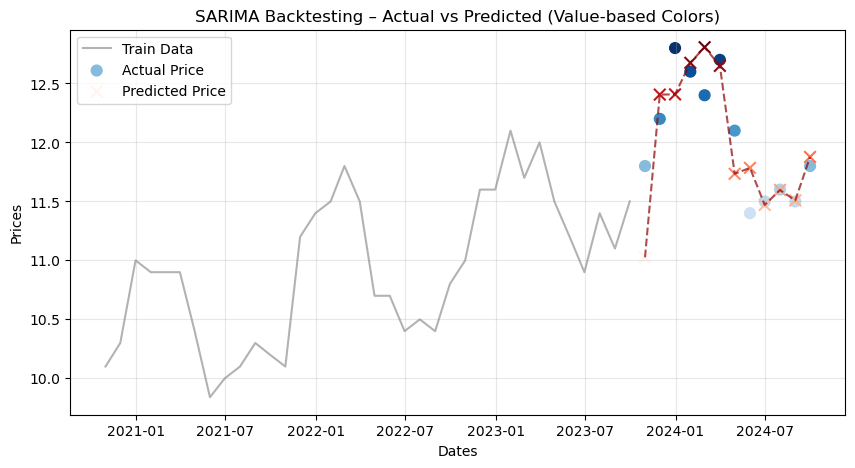

In [46]:
# -------------------------------
# 16. Backtesting Visualization
# -------------------------------

plt.figure(figsize=(10,5))

# Normalize prices for color intensity
norm = mcolors.Normalize(
    vmin=min(test['Prices'].min(), predicted_prices.min()),
    vmax=max(test['Prices'].max(), predicted_prices.max())
)

cmap_actual = plt.cm.Blues      # Actual → blue shades
cmap_pred   = plt.cm.Reds       # Predicted → red shades

# Train data (neutral color)
plt.plot(
    train.index,
    train['Prices'],
    label='Train Data',
    color='grey',
    alpha=0.6
)

# Actual prices (light → dark based on value)
plt.scatter(
    test.index,
    test['Prices'],
    c=test['Prices'],
    cmap=cmap_actual,
    norm=norm,
    label='Actual Price',
    s=60
)

# Predicted prices (light → dark based on value)
plt.scatter(
    test.index,
    predicted_prices,
    c=predicted_prices,
    cmap=cmap_pred,
    norm=norm,
    label='Predicted Price',
    marker='x',
    s=70
)

# Connect predicted line
plt.plot(
    test.index,
    predicted_prices,
    linestyle='--',
    color='darkred',
    alpha=0.7
)

plt.title("SARIMA Backtesting – Actual vs Predicted (Value-based Colors)")
plt.xlabel("Dates")
plt.ylabel("Prices")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [45]:
# Extract components
df['Year'] = df.index.year
df['Month'] = df.index.month
df['MonthName'] = df.index.strftime('%b')


In [47]:
# -------------------------------
# 17. Year split into 2 parts
# -------------------------------
df['Half'] = np.where(df['Month'] <= 6, 'H1 (Jan-Jun)', 'H2 (Jul-Dec)')


In [49]:
# -------------------------------
# 18. Month-wise Average Price
# -------------------------------
monthly_avg = df.groupby('MonthName')['Prices'].mean()
monthly_avg = monthly_avg.reindex(
    ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
)


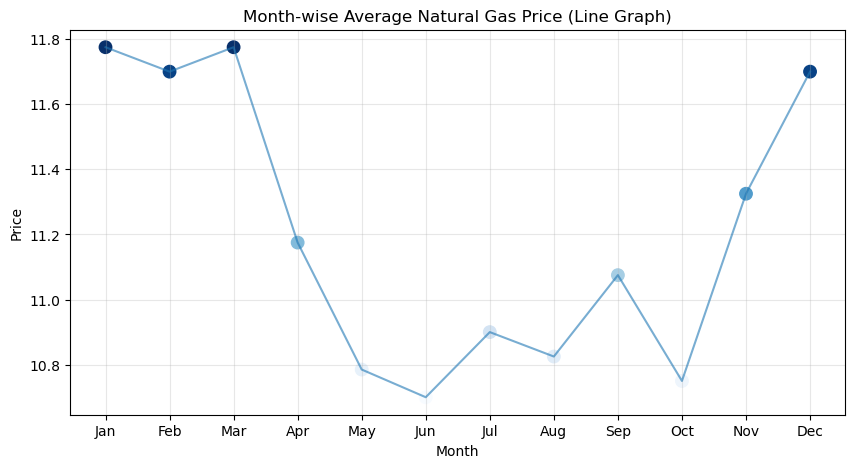

In [50]:
# -------------------------------
# 19. Line Graph (Month-wise) – value based color
# -------------------------------
import matplotlib.colors as mcolors

norm = mcolors.Normalize(
    vmin=monthly_avg.min(),
    vmax=monthly_avg.max()
)
cmap = plt.cm.Blues

plt.figure(figsize=(10,5))
plt.scatter(
    monthly_avg.index,
    monthly_avg.values,
    c=monthly_avg.values,
    cmap=cmap,
    norm=norm,
    s=80
)
plt.plot(monthly_avg.index, monthly_avg.values, alpha=0.6)
plt.title("Month-wise Average Natural Gas Price (Line Graph)")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(alpha=0.3)
plt.show()



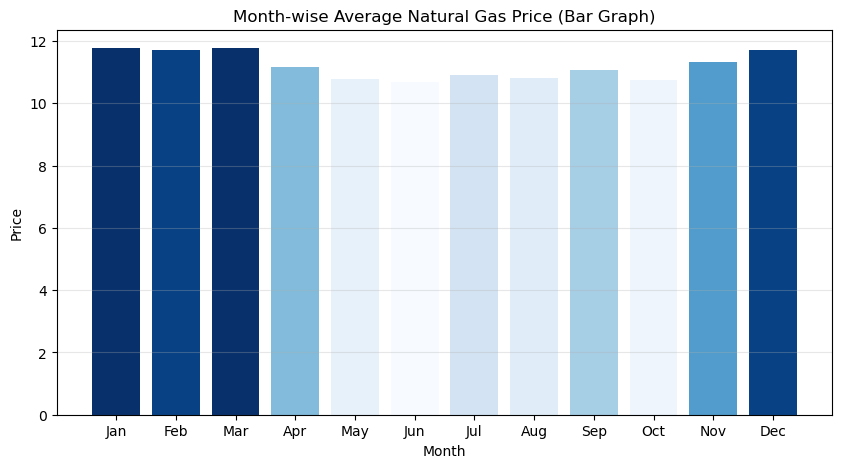

In [51]:

# -------------------------------
# 20. Bar Graph (Month-wise) – value based color
# -------------------------------
plt.figure(figsize=(10,5))
plt.bar(
    monthly_avg.index,
    monthly_avg.values,
    color=cmap(norm(monthly_avg.values))
)
plt.title("Month-wise Average Natural Gas Price (Bar Graph)")
plt.xlabel("Month")
plt.ylabel("Price")
plt.grid(axis='y', alpha=0.3)
plt.show()


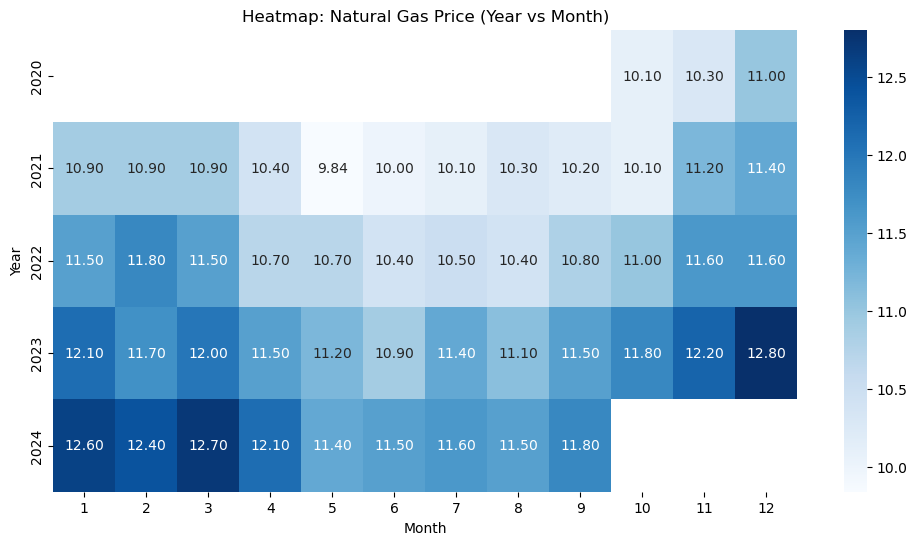

In [53]:
# -------------------------------
# 21. Heatmap (Year vs Month)
# -------------------------------
heatmap_data = df.pivot_table(
    values='Prices',
    index='Year',
    columns='Month',
    aggfunc='mean'
)

plt.figure(figsize=(12,6))
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt=".2f",
    cmap="Blues"
)
plt.title("Heatmap: Natural Gas Price (Year vs Month)")
plt.xlabel("Month")
plt.ylabel("Year")
plt.show()


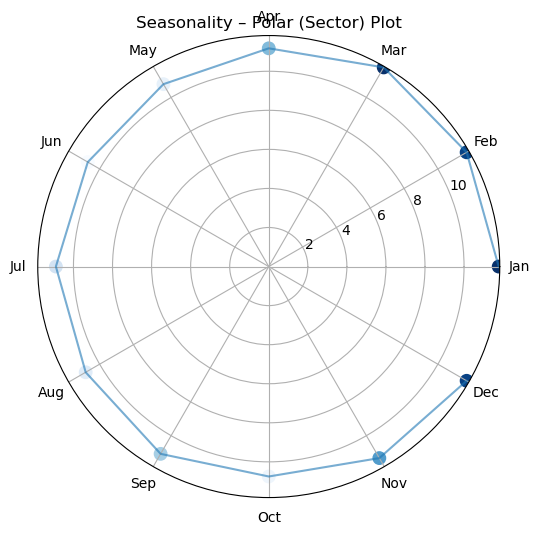

In [54]:

# -------------------------------
# 22. Sector / Polar Plot – value based color
# -------------------------------
angles = np.linspace(0, 2*np.pi, len(monthly_avg), endpoint=False)
prices = monthly_avg.values

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

ax.scatter(
    angles,
    prices,
    c=prices,
    cmap=cmap,
    norm=norm,
    s=80
)
ax.plot(angles, prices, alpha=0.6)

ax.set_xticks(angles)
ax.set_xticklabels(monthly_avg.index)
ax.set_title("Seasonality – Polar (Sector) Plot")
plt.show()


In [57]:
# -------------------------------
# 23. High vs Low Price Classification
# -------------------------------
median_price = df['Prices'].median()
df['PriceLevel'] = np.where(
    df['Prices'] >= median_price,
    'High Prices',
    'Low Prices'
)

price_counts = df['PriceLevel'].value_counts()


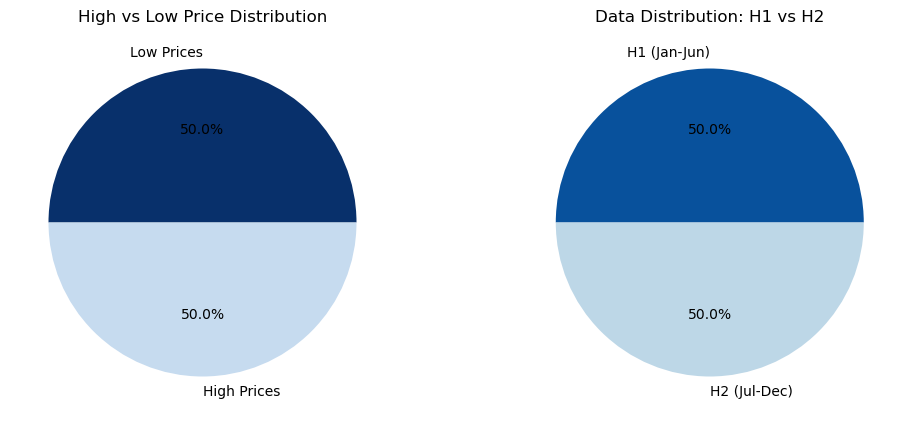

In [60]:

# -------------------------------
# 24. Pie Charts – dark = high, light = low
# -------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.pie(
    price_counts,
    labels=price_counts.index,
    autopct='%1.1f%%',
    colors=['#08306b', '#c6dbef']
)
plt.title("High vs Low Price Distribution")

plt.subplot(1,2,2)
plt.pie(
    df.groupby('Half')['Prices'].count(),
    labels=df.groupby('Half')['Prices'].count().index,
    autopct='%1.1f%%',
    colors=['#08519c', '#bdd7e7']
)
plt.title("Data Distribution: H1 vs H2")

plt.show()

In [62]:
# -------------------------------
# 25. Monthly Returns (for volatility)
# -------------------------------
df['Monthly_Return'] = df['Prices'].pct_change()


In [63]:
# -------------------------------
# 26. Rolling Standard Deviation
# -------------------------------
df['Rolling_STD_3M'] = df['Prices'].rolling(window=3).std()
df['Rolling_STD_6M'] = df['Prices'].rolling(window=6).std()
df['Rolling_STD_12M'] = df['Prices'].rolling(window=12).std()


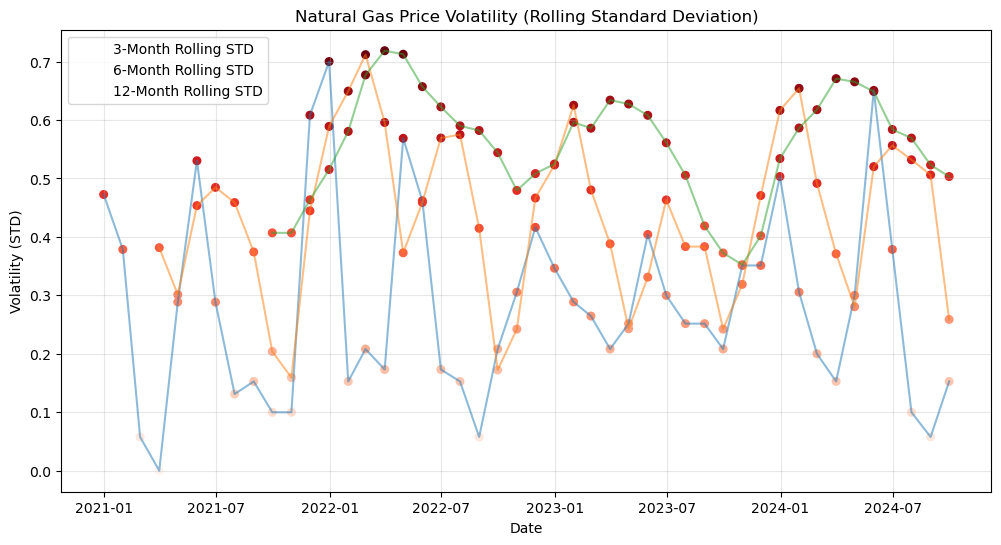

In [64]:
# -------------------------------
# 27. Volatility Plot (Rolling STD) – Reds (dark = high, light = low)
# -------------------------------
import matplotlib.colors as mcolors
import numpy as np

plt.figure(figsize=(12,6))

# Global normalization across all rolling stds
all_vals = pd.concat(
    [df['Rolling_STD_3M'], df['Rolling_STD_6M'], df['Rolling_STD_12M']]
)
norm = mcolors.Normalize(vmin=all_vals.min(), vmax=all_vals.max())
cmap = plt.cm.Reds

# 3M
plt.scatter(
    df.index,
    df['Rolling_STD_3M'],
    c=df['Rolling_STD_3M'],
    cmap=cmap,
    norm=norm,
    s=30,
    label='3-Month Rolling STD'
)
plt.plot(df.index, df['Rolling_STD_3M'], alpha=0.5)

# 6M
plt.scatter(
    df.index,
    df['Rolling_STD_6M'],
    c=df['Rolling_STD_6M'],
    cmap=cmap,
    norm=norm,
    s=30,
    label='6-Month Rolling STD'
)
plt.plot(df.index, df['Rolling_STD_6M'], alpha=0.5)

# 12M
plt.scatter(
    df.index,
    df['Rolling_STD_12M'],
    c=df['Rolling_STD_12M'],
    cmap=cmap,
    norm=norm,
    s=30,
    label='12-Month Rolling STD'
)
plt.plot(df.index, df['Rolling_STD_12M'], alpha=0.5)

plt.title("Natural Gas Price Volatility (Rolling Standard Deviation)")
plt.xlabel("Date")
plt.ylabel("Volatility (STD)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

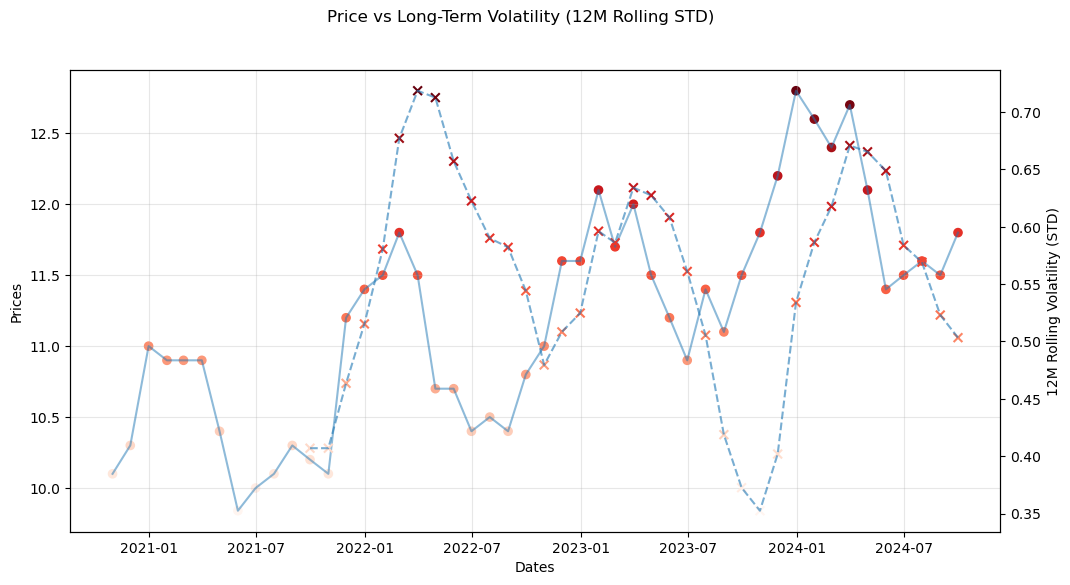

In [65]:
# -------------------------------
# 5. Price vs Volatility (Dual View)
# dark = high, light = low (Reds)
# -------------------------------
import matplotlib.colors as mcolors
import numpy as np

fig, ax1 = plt.subplots(figsize=(12,6))

# Normalization for price
price_norm = mcolors.Normalize(
    vmin=df['Prices'].min(),
    vmax=df['Prices'].max()
)
price_cmap = plt.cm.Reds

# Price scatter + line
ax1.scatter(
    df.index,
    df['Prices'],
    c=df['Prices'],
    cmap=price_cmap,
    norm=price_norm,
    s=35,
    label='Prices'
)
ax1.plot(df.index, df['Prices'], alpha=0.5)

ax1.set_xlabel("Dates")
ax1.set_ylabel("Prices")

# Normalization for volatility
vol_norm = mcolors.Normalize(
    vmin=df['Rolling_STD_12M'].min(),
    vmax=df['Rolling_STD_12M'].max()
)

ax2 = ax1.twinx()

# Volatility scatter + line
ax2.scatter(
    df.index,
    df['Rolling_STD_12M'],
    c=df['Rolling_STD_12M'],
    cmap=price_cmap,
    norm=vol_norm,
    marker='x',
    s=40,
    label='12M Volatility'
)
ax2.plot(df.index, df['Rolling_STD_12M'], linestyle='--', alpha=0.6)

ax2.set_ylabel("12M Rolling Volatility (STD)")

fig.suptitle("Price vs Long-Term Volatility (12M Rolling STD)")
ax1.grid(alpha=0.3)
plt.show()